In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
#import pytz
import scipy
import requests
import warnings
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

import extract_nba_rolling_stats

# Data

In [2]:
stat_categories = ['fpts']

In [3]:
def split_train_test(data, model_method):

    unique_game_dates = data[data['game_date'] >= '2022-01-01']['game_date'].unique()

    # Take 2023 and beyond to adjust for the rolling statistic
    split_date = unique_game_dates[int(len(unique_game_dates) * 0.7)]

    data['fpts_avg_met'] = (data['fpts'] >= data['player_fpts_mean']).astype(int)
    
    train = data[data['game_date'] <= split_date]
    test = data[data['game_date'] > split_date]
        
        # Independent and Dependent variables
    ## Complete
    # ((col == 'min')
    #   | (('opponent_team_opp_' in col)
    #      & ('_stand' in col))
    #  )
    # ((col == 'min')
    #   | (('opponent_team_opp_' in col)
    #      & ('_pg' in col))
    #  )
    ## Try
    # ((('player_' in col)
    #    & ('mean' in col)
    #    & ('league' not in col))
    #   | (('opponent_team_opp_' in col)
    #      & ('_pg' in col))
    #  )
    X_cols = [col for col in data.columns if ((('_mean_stand' in col)
                                               & ('league' not in col))
                                              | (col == 'min_stand')
                                              # | (('team_' in col)
                                              #    & ('_pg_stand' in col)
                                              #    & ('opp_' not in col))
                                              | (('opponent_team_opp_' in col)
                                                 & ('_pg' in col)
                                                & ('_stand' in col))
                                             )
             ]

    if model_method == 'regressor':
        y_cols = [col for col in data.columns if '_normed' in col]
    elif model_method == 'classification':
        y_cols = [col for col in data.columns if '_avg_met' in col]
    
    # Training set
    X_train = train[X_cols].dropna()
    y_train = train.loc[X_train.index,
                        y_cols]
    
    # Test set
    X_test = test[X_cols].dropna()
    y_test = test.loc[X_test.index,
                    y_cols]
    
    return X_train, X_test, y_train, y_test

# Regression

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

## ANN Model

In [5]:
import json
from keras.models import model_from_json

#50, 50, 50, 50, 50, 20, 20, 10, 10, 5
best_model_regress = model_from_json(open('./Models/nn_regress_fpts_(50,50,50,50,50,20,20,10,10,5)_15 rp.json').read())

best_model_regress.load_weights('./Models/nn_regress_fpts_(50,50,50,50,50,20,20,10,10,5)_15 rp.h5')

### Data

In [6]:
# ANN regressor rolling period
script_run_extract_15 = extract_nba_rolling_stats.run_extract(15,
                                                          stat_categories)

extract_data_15 = script_run_extract_15.extracted_data
rolling_data_15 = script_run_extract_15.rolling_shifted_data
standard_data_15 = script_run_extract_15.standardized_data

Calculating stats for ['fpts']
Reading in Stats
Reading in Games
Reading in Players
Calculating individual team rolling statistics...
Shifting data...
Calculating league team rolling statistics...
Shifting data...
Calculating individual player rolling statistics...
Shifting data...
Calculating league player rolling statistics...
Shifting data...
Merging all data...
Standardizing data...
Done!


In [7]:
X_train_15, X_test_15, y_train_reg_15, y_test_reg_15 = split_train_test(standard_data_15, model_method = 'regressor')

### Evaluation

In [8]:
y_pred_regress_nn = pd.DataFrame(best_model_regress.predict(X_test_15),
                      columns = ['fpts_normed'])

501/501 [==============================] - 2s 3ms/step


In [9]:
y_test_reg_15['fpts'] = y_test_reg_15['fpts_normed'].apply(lambda x: x**2)
y_pred_regress_nn['fpts'] = y_pred_regress_nn['fpts_normed'].apply(lambda x: x**2)

In [10]:
mse_normed_nn = mean_squared_error(y_test_reg_15[['fpts_normed']],
                         y_pred_regress_nn[['fpts_normed']],
                        squared = True)

rmse_nn = mean_squared_error(y_test_reg_15[['fpts']],
                         y_pred_regress_nn[['fpts']],
                        squared = False)

r_squared_nn = r2_score(y_test_reg_15[['fpts']],
                     y_pred_regress_nn[['fpts']])

print('Normed MSE = %f' %mse_normed_nn)
print('Root Mean Squared Error = %f' %rmse_nn)
print('R Squared = %f' %r_squared_nn)

# Residual plot
residuals_nn = y_test_reg_15['fpts'].values - y_pred_regress_nn['fpts'].values
print('Sum of residuals = %f' %sum(residuals_nn))

Normed MSE = 0.797562
Root Mean Squared Error = 8.072383
R Squared = 0.713245
Sum of residuals = 22745.228856


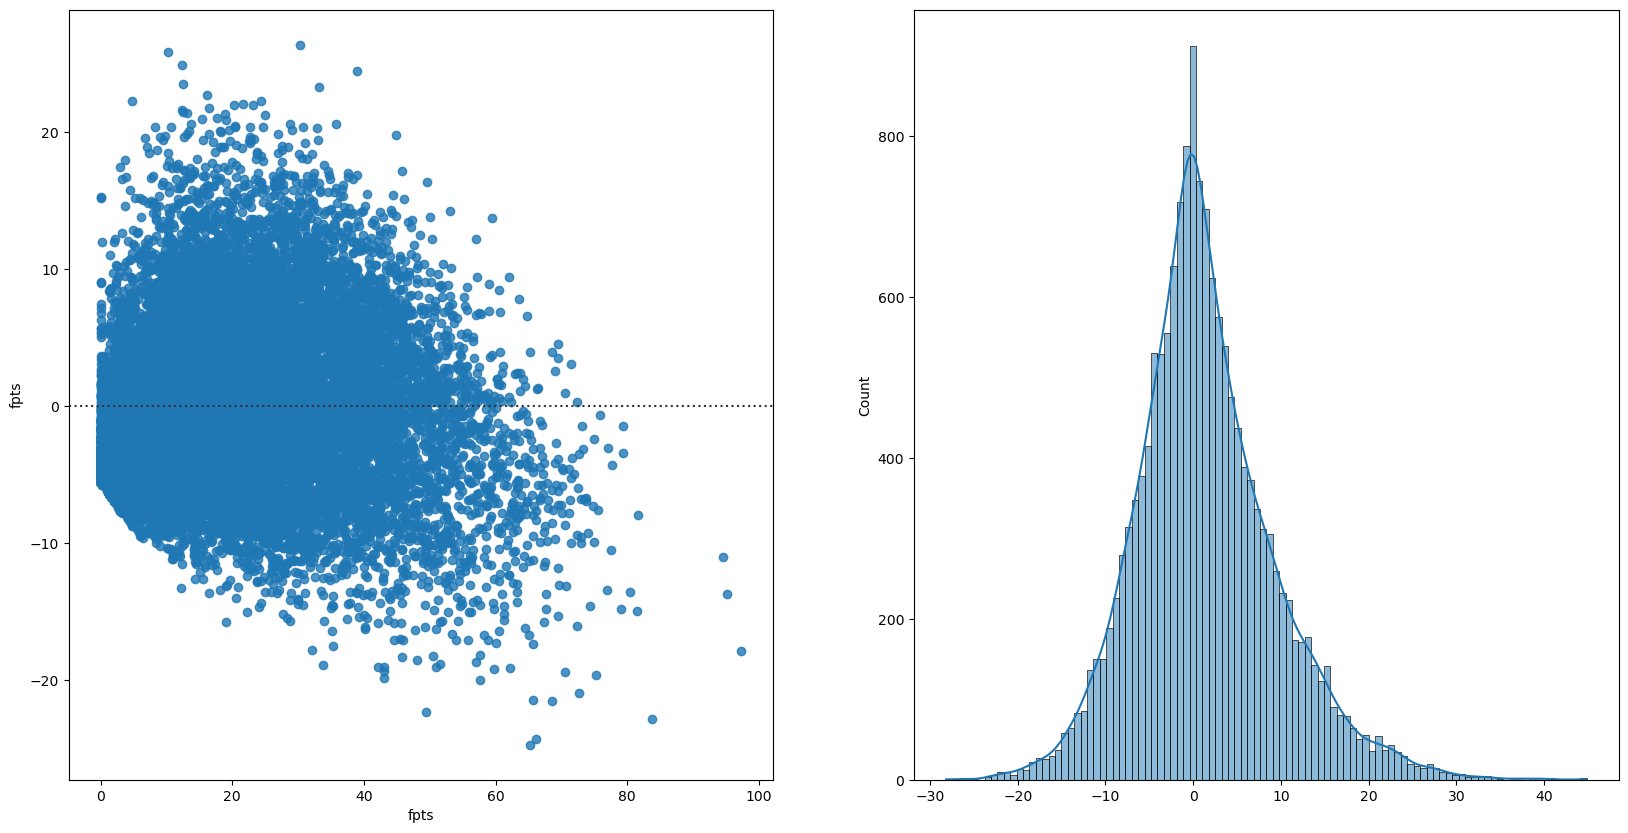

0.5638742083636992


In [11]:
fig, axes = plt.subplots(1,2,
                         figsize = (20,10))
sns.residplot(ax = axes[0],
              x = y_test_reg_15['fpts'],
             y = y_pred_regress_nn['fpts'])

sns.histplot(ax = axes[1],
            data = residuals_nn,
           kde = True)
plt.show()

print(scipy.stats.skew(residuals_nn))

## Random Forest Regressor

In [12]:
# Save trained model
import pickle

model_file_name = './Models/rf_regress_model_fpts.pkl'

with open(model_file_name, 'rb') as file:
    final_rf_regress = pickle.load(file)

### Data

In [13]:
# RandomForest regressor rolling period
script_run_extract_30 = extract_nba_rolling_stats.run_extract(30,
                                                          stat_categories)

extract_data_30 = script_run_extract_30.extracted_data
rolling_data_30 = script_run_extract_30.rolling_shifted_data
standard_data_30 = script_run_extract_30.standardized_data

Calculating stats for ['fpts']
Reading in Stats
Reading in Games
Reading in Players
Calculating individual team rolling statistics...
Shifting data...
Calculating league team rolling statistics...
Shifting data...
Calculating individual player rolling statistics...
Shifting data...
Calculating league player rolling statistics...
Shifting data...
Merging all data...
Standardizing data...
Done!


In [14]:
X_train_30, X_test_30, y_train_reg_30, y_test_reg_30 = split_train_test(standard_data_30, model_method = 'regressor')

### Evaluation

In [15]:
y_pred_regress_rf = pd.DataFrame(final_rf_regress.predict(X_test_30),
                      columns = ['fpts_normed']
                                )

In [16]:
y_test_reg_30['fpts'] = y_test_reg_30['fpts_normed'].apply(lambda x: x**2)
y_pred_regress_rf['fpts'] = y_pred_regress_rf['fpts_normed'].apply(lambda x: x**2)

In [17]:
mse = mean_squared_error(y_test_reg_30[['fpts']],
                         y_pred_regress_rf[['fpts']],
                        squared = False)

r_squared = r2_score(y_test_reg_30[['fpts']],
                     y_pred_regress_rf[['fpts']])

print('Root Mean Squared Error = %f' %mse)
print('R Squared = %f' %r_squared)

# Residual plot
residuals_rf = y_test_reg_30['fpts'].values - y_pred_regress_rf['fpts'].values
print('Sum of residuals = %f' %sum(residuals_rf))

Root Mean Squared Error = 8.109106
R Squared = 0.710630
Sum of residuals = 19682.439360


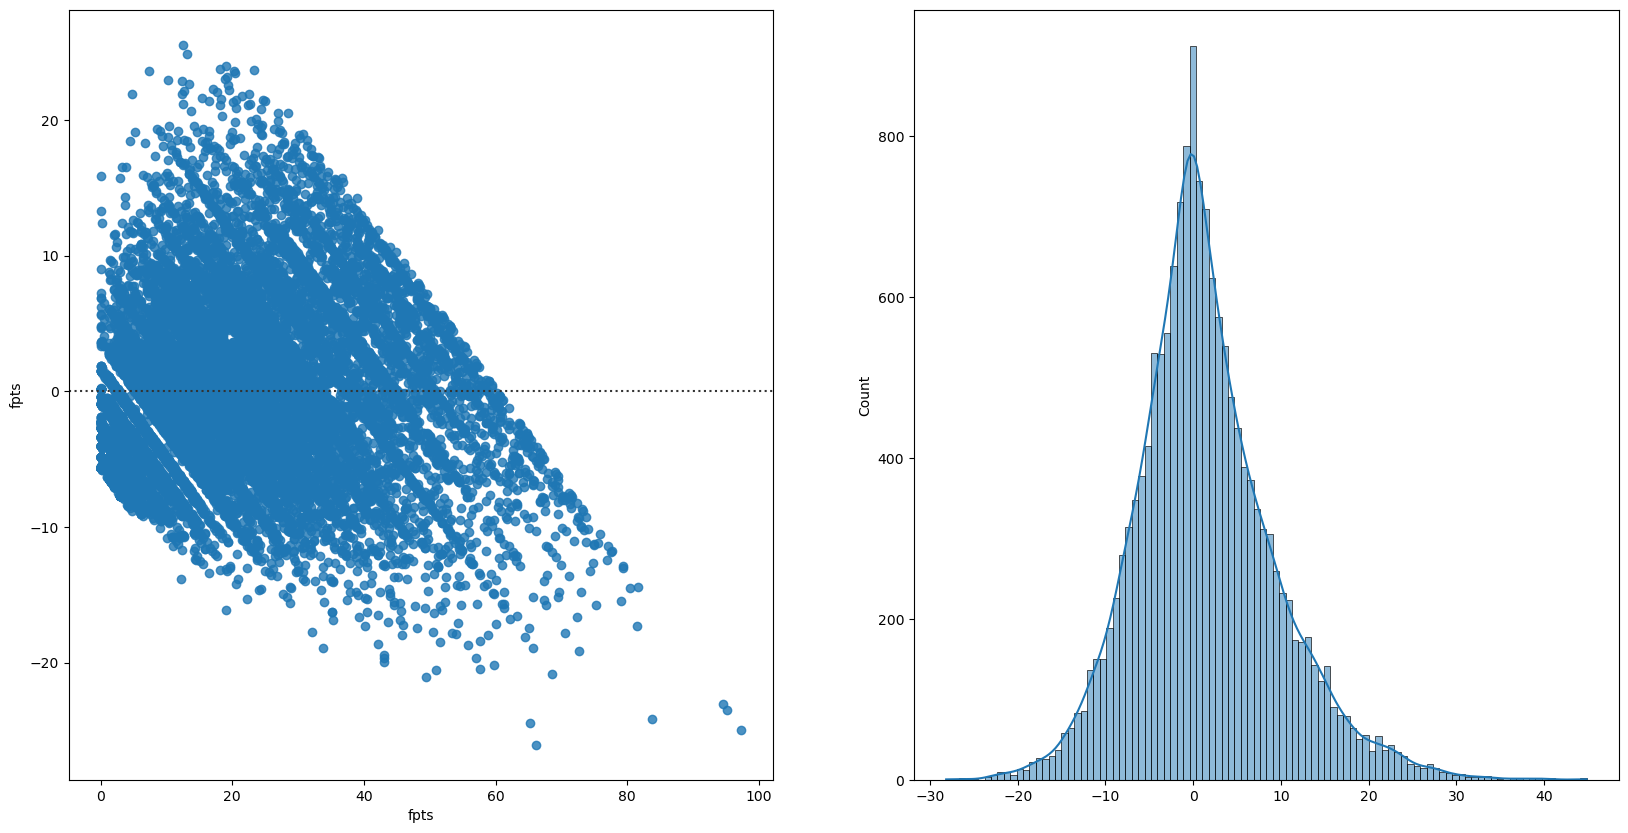

0.5638742083636992


In [18]:
fig, axes = plt.subplots(1,2,
                         figsize = (20,10))
sns.residplot(ax = axes[0],
              x = y_test_reg_30['fpts'],
             y = y_pred_regress_rf['fpts'])

sns.histplot(ax = axes[1],
            data = residuals_nn,
           kde = True)
plt.show()

print(scipy.stats.skew(residuals_nn))

# Classification

In [19]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, classification_report, roc_curve

## ANN Calssification Model

In [20]:
best_model = model_from_json(open('./Models/nn_class_fpts_(50,50,20,10,5,5)_50 rp.json').read())

best_model.load_weights('./Models/nn_class_fpts_(50,50,20,10,5,5)_50 rp.h5')

### Data

In [21]:
# ANN classifier rolling period
script_run_extract_50 = extract_nba_rolling_stats.run_extract(50,
                                                          stat_categories)

extract_data_50 = script_run_extract_50.extracted_data
rolling_data_50 = script_run_extract_50.rolling_shifted_data
standard_data_50 = script_run_extract_50.standardized_data

Calculating stats for ['fpts']
Reading in Stats
Reading in Games
Reading in Players
Calculating individual team rolling statistics...
Shifting data...
Calculating league team rolling statistics...
Shifting data...
Calculating individual player rolling statistics...
Shifting data...
Calculating league player rolling statistics...
Shifting data...
Merging all data...
Standardizing data...
Done!


In [22]:
X_train_50, X_test_50, y_train_class_50, y_test_class_50 = split_train_test(standard_data_50, model_method = 'classification')

### Evaluation

In [23]:
y_pred_class_nn = pd.DataFrame(best_model.predict(X_test_50),
                      columns = ['fpts_avg_met'])

501/501 [==============================] - 2s 4ms/step


In [24]:
y_pred_proba_class_nn = best_model.predict(X_test_50)

501/501 [==============================] - 2s 4ms/step


In [25]:
y_pred_class_nn = y_pred_proba_class_nn.copy()

threshold_nn = 0.5

y_pred_class_nn[y_pred_class_nn >= threshold_nn] = 1
y_pred_class_nn[y_pred_class_nn < threshold_nn] = 0

In [26]:
nn_class_cm = confusion_matrix(y_test_class_50,
                                 y_pred_class_nn)

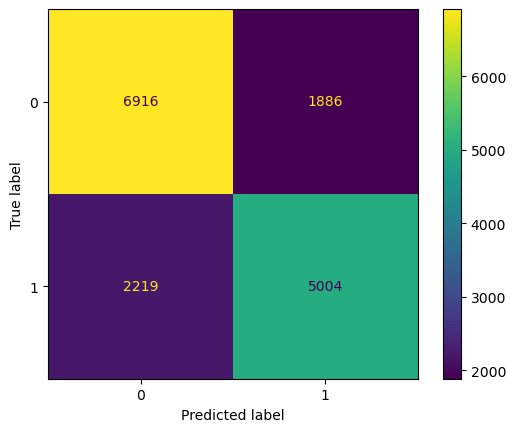

In [27]:
cm_plot = ConfusionMatrixDisplay(nn_class_cm)
cm_plot.plot()
plt.show()

In [28]:
tp_nn,fp_nn,fn_nn,tn_nn = nn_class_cm.ravel()

In [29]:
sensitivity_nn = tp_nn/(tp_nn+fn_nn)
specificity_nn = tn_nn/(tn_nn+fp_nn)
precision_nn = tp_nn/(tp_nn+fp_nn)

In [30]:
print(classification_report(y_test_class_50, y_pred_class_nn))
print('ROCAUC = %.3f' %roc_auc_score(y_test_class_50, y_pred_proba_class_nn))
print('Sensitivity = %.3f' %sensitivity_nn)
print('Sepcificity = %.3f' %specificity_nn)
print('Precision = %.3f' %precision_nn)

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      8802
           1       0.73      0.69      0.71      7223

    accuracy                           0.74     16025
   macro avg       0.74      0.74      0.74     16025
weighted avg       0.74      0.74      0.74     16025

ROCAUC = 0.828
Sensitivity = 0.757
Sepcificity = 0.726
Precision = 0.786


## Random Forest Classifier

In [31]:
# Save trained model
import pickle

model_file_name = './Models/rf_class_model_fpts.pkl'

with open(model_file_name, 'rb') as file:
    final_rf_class = pickle.load(file)

### Data

In [32]:
# RandomForest classifier rolling period
script_run_extract_60 = extract_nba_rolling_stats.run_extract(60,
                                                          stat_categories)

extract_data_60 = script_run_extract_60.extracted_data
rolling_data_60 = script_run_extract_60.rolling_shifted_data
standard_data_60 = script_run_extract_60.standardized_data

Calculating stats for ['fpts']
Reading in Stats
Reading in Games
Reading in Players
Calculating individual team rolling statistics...
Shifting data...
Calculating league team rolling statistics...
Shifting data...
Calculating individual player rolling statistics...
Shifting data...
Calculating league player rolling statistics...
Shifting data...
Merging all data...
Standardizing data...
Done!


In [33]:
X_train_60, X_test_60, y_train_class_60, y_test_class_60 = split_train_test(standard_data_60, model_method = 'classification')

### Evaluation

In [34]:
y_pred_class_rf = pd.DataFrame(final_rf_class.predict(X_test_60),
                      columns = ['fpts_avg_met'])

In [35]:
y_pred_class_rf = final_rf_class.predict(X_test_60)
y_pred_proba_rf = final_rf_class.predict_proba(X_test_60)

In [36]:
rf_class_cm = confusion_matrix(y_test_class_60,
                                 y_pred_class_rf)

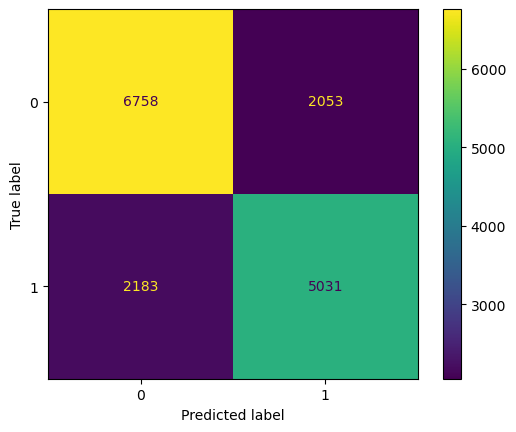

In [37]:
cm_plot = ConfusionMatrixDisplay(rf_class_cm)
cm_plot.plot()
plt.show()

In [38]:
tp_rf,fp_rf,fn_rf,tn_rf = rf_class_cm.ravel()

In [39]:
sensitivity_rf = tp_rf/(tp_rf+fn_rf)
specificity_rf = tn_rf/(tn_rf+fp_rf)
precision_rf = tp_rf/(tp_rf+fp_rf)

In [40]:
y_pred_proba_rf[1]

array([0.29237944, 0.70762056])

In [41]:
print(classification_report(y_test_class_60, y_pred_class_rf))
print('ROCAUC = %.3f' %roc_auc_score(y_test_class_60, y_pred_proba_rf[:,1]))
print('Sensitivity = %.3f' %sensitivity_rf)
print('Sepcificity = %.3f' %specificity_rf)
print('Precision = %.3f' %precision_rf)

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      8811
           1       0.71      0.70      0.70      7214

    accuracy                           0.74     16025
   macro avg       0.73      0.73      0.73     16025
weighted avg       0.74      0.74      0.74     16025

ROCAUC = 0.822
Sensitivity = 0.756
Sepcificity = 0.710
Precision = 0.767


# Compare All Models to Test

## y Data

In [95]:
actuals = y_test_reg_30[['fpts']].rename(columns = {'fpts':'fpts_actual'})

In [96]:
nn_regress_pred = y_pred_regress_nn[['fpts']].rename(columns = {'fpts':'fpts_nn_regress'})
nn_regress_pred.index = actuals.index

In [97]:
rf_regress_pred = y_pred_regress_rf[['fpts']].rename(columns = {'fpts':'fpts_rf_regress'})
rf_regress_pred.index = actuals.index

In [98]:
nn_class_pred = pd.DataFrame(y_pred_class_nn,
                             columns = ['fpts_nn_class'])
nn_class_pred.index = actuals.index

In [99]:
rf_class_pred = pd.DataFrame(y_pred_class_rf,
                             columns = ['fpts_rf_class'])
rf_class_pred.index = actuals.index

In [100]:
all_y = pd.concat([actuals,
                   nn_regress_pred,
                   rf_regress_pred,
                   nn_class_pred,
                   rf_class_pred],
                  axis = 1,
                 ignore_index = False)

## X data

In [101]:
X_data_meta = standard_data_15[standard_data_15.index.isin(all_y.index)]\
                [['game_date','player_id','player_position',
                 'team_id','opponent_team_id',
                 'min','player_fpts_per36']]

In [102]:
X_data_15 = standard_data_15[standard_data_15.index.isin(all_y.index)]\
                [['player_fpts_mean',
                 # 'opponent_team_opp_fpts_pg'
                 ]]\
                .rename(columns = {'player_fpts_mean':'player_fpts_mean_15',
                                   # 'opponent_team_opp_fpts_pg':'opponent_team_opp_fpts_pg_15'
                                  })

In [103]:
X_data_30 = standard_data_30[standard_data_30.index.isin(all_y.index)]\
                [['player_fpts_mean',
                 # 'opponent_team_opp_fpts_pg'
                 ]]\
                .rename(columns = {'player_fpts_mean':'player_fpts_mean_30',
                                   # 'opponent_team_opp_fpts_pg':'opponent_team_opp_fpts_pg_30'
                                  })

In [104]:
X_data_50 = standard_data_50[standard_data_50.index.isin(all_y.index)]\
                [['player_fpts_mean',
                 # 'opponent_team_opp_fpts_pg'
                 ]]\
                .rename(columns = {'player_fpts_mean':'player_fpts_mean_50',
                                   # 'opponent_team_opp_fpts_pg':'opponent_team_opp_fpts_pg_50'
                                  })

In [105]:
X_data_60 = standard_data_60[standard_data_60.index.isin(all_y.index)]\
                [['player_fpts_mean',
                 # 'opponent_team_opp_fpts_pg'
                 ]]\
                .rename(columns = {'player_fpts_mean':'player_fpts_mean_60',
                                   # 'opponent_team_opp_fpts_pg':'opponent_team_opp_fpts_pg_60'
                                  })

In [106]:
all_X = pd.concat([X_data_meta,
                   X_data_15,
                   X_data_30,
                   X_data_50,
                   X_data_60],
                  axis = 1,
                  ignore_index = False)

## Comparison

In [107]:
eval_test_data = pd.concat([all_X,
                       all_y],
                      axis = 1)

In [108]:
# Did regression models predict average was met?
eval_test_data['fpts_nn_regress_class'] = (eval_test_data['fpts_nn_regress'] >= eval_test_data['player_fpts_mean_15']).astype(int)
eval_test_data['fpts_rf_regress_class'] = (eval_test_data['fpts_rf_regress'] >= eval_test_data['player_fpts_mean_30']).astype(int)

# True values if player met averages
for i in [15, 30, 50, 60]:
    eval_test_data['fpts_avg_met_%i' %i] = (eval_test_data['fpts_actual'] >= eval_test_data['player_fpts_mean_%i' %i]).astype(int)

In [109]:
rf_class_cm = confusion_matrix(y_test_class_60,
                                 y_pred_class_rf)

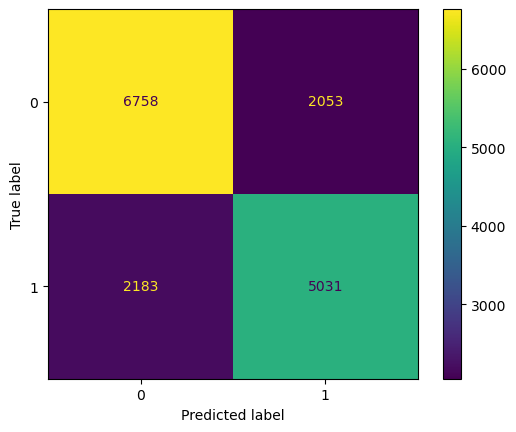

In [110]:
cm_plot = ConfusionMatrixDisplay(rf_class_cm)
cm_plot.plot()
plt.show()

In [111]:
tp_rf,fp_rf,fn_rf,tn_rf = rf_class_cm.ravel()

In [112]:
sensitivity_rf = tp_rf/(tp_rf+fn_rf)
specificity_rf = tn_rf/(tn_rf+fp_rf)
precision_rf = tp_rf/(tp_rf+fp_rf)
accuracy_rf = (tp_rf + tn_rf)/(rf_class_cm.sum())

In [113]:
y_pred_proba_rf[1]

array([0.29237944, 0.70762056])

In [114]:
print(classification_report(y_test_class_60, y_pred_class_rf))
print('ROCAUC = %.3f' %roc_auc_score(y_test_class_60, y_pred_proba_rf[:,1]))
print('Sensitivity = %.3f' %sensitivity_rf)
print('Sepcificity = %.3f' %specificity_rf)
print('Precision = %.3f' %precision_rf)

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      8811
           1       0.71      0.70      0.70      7214

    accuracy                           0.74     16025
   macro avg       0.73      0.73      0.73     16025
weighted avg       0.74      0.74      0.74     16025

ROCAUC = 0.822
Sensitivity = 0.756
Sepcificity = 0.710
Precision = 0.767


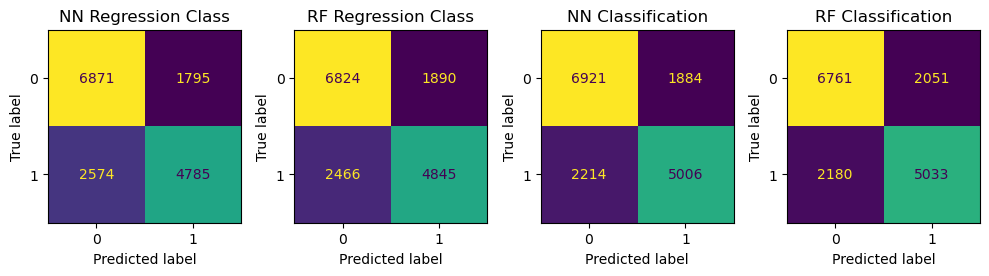

In [124]:
rp_cols = {15:['fpts_nn_regress_class','fpts_avg_met_15','NN Regression Class'],
           30:['fpts_rf_regress_class','fpts_avg_met_30','RF Regression Class'],
           50:['fpts_nn_class','fpts_avg_met_50','NN Classification'],
           60:['fpts_rf_class','fpts_avg_met_60','RF Classification']
          }

fig,axes = plt.subplots(1,4,
                      figsize = (10,40))
metrics_df = pd.DataFrame()

for i in rp_cols:
    class_cm = confusion_matrix(eval_test_data[rp_cols[i][1]],
                                 eval_test_data[rp_cols[i][0]])

    cm_plot = ConfusionMatrixDisplay(class_cm)
    cm_plot.plot(ax = axes[list(rp_cols.keys()).index(i)],
                colorbar = False)
    cm_plot.ax_.set_title(rp_cols[i][2])

    tp,fp,fn,tn = class_cm.ravel()
    
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    accuracy = (tp + tn)/(class_cm.sum())

    model_metrics_df = pd.DataFrame([sensitivity,
                                     specificity,
                                     precision,
                                     accuracy],
                                    index = ['Sensitivity',
                                             'Specificity',
                                             'Precision',
                                             'Accuracy'],
                                   columns = [rp_cols[i][2]])
    metrics_df = pd.concat([metrics_df,
                           model_metrics_df],
                          axis = 1)

plt.tight_layout()
plt.show()

In [125]:
metrics_df

,NN Regression Class,RF Regression Class,NN Classification,RF Classification
Sensitivity,0.727475,0.734553,0.757635,0.756179
Specificity,0.727204,0.719376,0.726560,0.710474
Precision,0.792869,0.783108,0.786031,0.767249
Accuracy,0.727363,0.728175,0.744275,0.735975


In [ ]:
# NN Classification performs best based on accuracy
# Perfer accuracy as metric due to desire to predict if player meet or don't meet their average